# Esperanza's Data Re-cleaning Notebook

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import prophet as Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
# Prophet import gives: "Importing plotly failed. Interactive plots will not work."
# Imported everything for Jupyter Notebook and plotly to cooperate but it still isn't

## Grabbing Data from Data/Out

In [2]:
# this path is based on my workflow with virtual environment - path will need to be changed

#floor_data = pd.read_csv('Capstone-Brick-Modeling/data/temp/combined_floors.csv')

In [3]:
time_val = '1H'

In [4]:
#col_list = ['time', 'Common Setpoint', 'Actual Sup Flow SP', 'Zone Temperature', 'Actual Supply Flow', 'Outside Air Temp', 'Humidity', 'energy']

floor_2 = pd.read_csv('Capstone-Brick-Modeling/data/raw/merged_all_2F.csv', index_col = 'Unnamed: 0')
floor_3 = pd.read_csv('Capstone-Brick-Modeling/data/raw/merged_all_3F.csv', index_col = 'Unnamed: 0')
floor_4 = pd.read_csv('Capstone-Brick-Modeling/data/raw/merged_all_4F.csv', index_col = 'Unnamed: 0')

In [5]:
# one version of this is Unnamed: 0.2 but I'm not sure why this one says 

floor_2 = floor_2.drop(['Unnamed: 0.1.1', 'Unnamed: 0.1'], axis = 1)

In [6]:
floor_2['time_transformed'] = pd.to_datetime(floor_2['time'])
floor_2['time_floored'] = floor_2['time_transformed'].transform(lambda x: x.floor(freq=time_val))

In [7]:
floor_2.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored
0,2018-01-03T20:57:39+00:00,72.5,330.0,75.2,318.73,10.109642,68.44,56.0,75.2,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:00:00+00:00
1,2018-01-03T21:04:13+00:00,72.5,330.0,75.2,317.06,10.113301,68.50,56.0,75.7,314.34,68.25,56.0,10.099466,2018-01-03 21:04:13+00:00,2018-01-03 21:00:00+00:00
2,2018-01-03T21:10:44+00:00,72.5,330.0,75.7,314.34,10.099466,68.25,56.0,75.7,313.91,68.31,56.0,10.241028,2018-01-03 21:10:44+00:00,2018-01-03 21:00:00+00:00
3,2018-01-03T21:17:16+00:00,72.5,330.0,75.7,313.91,10.241028,68.31,56.0,75.7,318.31,68.44,57.0,10.187620,2018-01-03 21:17:16+00:00,2018-01-03 21:00:00+00:00
4,2018-01-03T21:23:44+00:00,72.5,330.0,75.7,318.31,10.187620,68.44,57.0,75.7,316.65,68.81,57.0,10.194055,2018-01-03 21:23:44+00:00,2018-01-03 21:00:00+00:00


In [8]:
floor_3 = floor_3.drop(['Unnamed: 0.1'], axis = 1)

In [9]:
floor_3['time_transformed'] = pd.to_datetime(floor_3['time'])
floor_3['time_floored'] = floor_3['time_transformed'].transform(lambda x: x.floor(freq=time_val))

In [10]:
floor_3.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored
0,2018-07-05T00:58:48+00:00,72.0,295.0,73.75,287.56,9.067059,68.88,53.0,73.75,289.97,69.31,53.0,9.104582,2018-07-05 00:58:48+00:00,2018-07-05 00:00:00+00:00
1,2018-07-05T01:04:13+00:00,72.0,295.0,73.75,289.97,9.104582,69.31,53.0,73.75,291.17,68.88,53.0,9.377247,2018-07-05 01:04:13+00:00,2018-07-05 01:00:00+00:00
2,2018-07-05T01:09:37+00:00,72.0,295.0,73.75,291.17,9.377247,68.88,53.0,73.75,299.89,68.94,53.0,9.147068,2018-07-05 01:09:37+00:00,2018-07-05 01:00:00+00:00
3,2018-07-05T01:15:17+00:00,72.0,295.0,73.75,299.89,9.147068,68.94,53.0,73.75,294.97,69.13,53.0,9.198235,2018-07-05 01:15:17+00:00,2018-07-05 01:00:00+00:00
4,2018-07-05T01:20:55+00:00,72.0,295.0,73.75,294.97,9.198235,69.13,53.0,73.75,296.62,68.94,53.0,9.212810,2018-07-05 01:20:55+00:00,2018-07-05 01:00:00+00:00


In [11]:
floor_4 = floor_4.drop(['Unnamed: 0.1'], axis = 1)

In [12]:
floor_4['time_transformed'] = pd.to_datetime(floor_4['time'])
floor_4['time_floored'] = floor_4['time_transformed'].transform(lambda x: x.floor(freq=time_val))

In [13]:
floor_4.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored
0,2018-09-23T22:59:39+00:00,72.0,722.73,75.25,733.46,23.554224,71.31,53.0,74.74,692.03,71.19,53.0,22.261861,2018-09-23 22:59:39+00:00,2018-09-23 22:00:00+00:00
1,2018-09-23T23:06:38+00:00,72.0,661.39,74.74,692.03,22.261861,71.19,53.0,74.74,654.06,71.19,53.0,19.471076,2018-09-23 23:06:38+00:00,2018-09-23 23:00:00+00:00
2,2018-09-23T23:13:38+00:00,72.0,624.95,74.74,654.06,19.471076,71.19,53.0,74.24,576.94,70.94,53.0,18.861571,2018-09-23 23:13:38+00:00,2018-09-23 23:00:00+00:00
3,2018-09-23T23:20:38+00:00,72.0,562.05,74.24,576.94,18.861571,70.94,53.0,74.24,558.88,70.94,53.0,17.087055,2018-09-23 23:20:38+00:00,2018-09-23 23:00:00+00:00
4,2018-09-23T23:27:37+00:00,72.0,532.93,74.24,558.88,17.087055,70.94,53.0,74.24,506.30,70.81,53.0,16.212959,2018-09-23 23:27:37+00:00,2018-09-23 23:00:00+00:00


In [14]:
#floor_2['floor'] = 2
#floor_3['floor'] = 3
#floor_4['floor'] = 4

In [15]:
grouped_df = pd.concat([floor_2, floor_3, floor_4])

In [16]:
grouped_df.loc[:, 'hour'] = grouped_df['time_floored'].transform(lambda x: x.hour)

In [17]:
split_date = "2018-08-01"

In [19]:
# DO TRAIN TEST SPLIT HERE:
train_set = grouped_df.loc[grouped_df['time_floored'] < split_date, :]
test_set = grouped_df.loc[~(grouped_df['time_floored'] < split_date), :]

In [20]:
train_set.tail(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored,hour
549,2018-06-25T22:27:03+00:00,73.0,342.12,74.16,376.16,11.431719,68.19,53.0,74.16,351.59,68.00,53.0,10.977169,2018-06-25 22:27:03+00:00,2018-06-25 22:00:00+00:00,22
550,2018-06-25T22:32:09+00:00,73.0,329.45,74.16,351.59,10.977169,68.00,53.0,74.16,337.61,67.63,53.0,12.475430,2018-06-25 22:32:09+00:00,2018-06-25 22:00:00+00:00,22
551,2018-06-25T22:37:17+00:00,73.0,362.76,74.16,337.61,12.475430,67.63,53.0,74.16,383.69,67.56,53.0,12.558016,2018-06-25 22:37:17+00:00,2018-06-25 22:00:00+00:00,22
552,2018-06-25T22:42:31+00:00,73.0,393.99,74.16,383.69,12.558016,67.56,53.0,74.16,386.23,67.19,53.0,12.651983,2018-06-25 22:42:31+00:00,2018-06-25 22:00:00+00:00,22
553,2018-06-25T22:47:43+00:00,73.0,390.03,74.16,386.23,12.651983,67.19,53.0,74.16,389.12,68.19,53.0,12.475430,2018-06-25 22:47:43+00:00,2018-06-25 22:00:00+00:00,22


In [19]:
# gap in July and August 2018 that this splits
# based on about 70% data split based on original data points

In [21]:
test_set.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored,hour
0,2018-09-03T01:02:18+00:00,72.0,295.49,71.26,292.91,9.038064,71.25,53.0,71.26,282.13,71.25,53.0,9.020124,2018-09-03 01:02:18+00:00,2018-09-03 01:00:00+00:00,1
1,2018-09-03T01:09:23+00:00,72.0,295.49,71.26,282.13,9.020124,71.25,53.0,71.26,281.57,71.19,53.0,8.966305,2018-09-03 01:09:23+00:00,2018-09-03 01:00:00+00:00,1
2,2018-09-03T01:16:28+00:00,72.0,295.49,71.26,281.57,8.966305,71.19,53.0,71.26,279.89,71.00,53.0,9.121355,2018-09-03 01:16:28+00:00,2018-09-03 01:00:00+00:00,1
3,2018-09-03T01:23:32+00:00,72.0,295.49,71.26,279.89,9.121355,71.00,53.0,71.26,284.73,70.94,53.0,8.978479,2018-09-03 01:23:32+00:00,2018-09-03 01:00:00+00:00,1
4,2018-09-03T01:30:36+00:00,72.0,295.49,71.26,284.73,8.978479,70.94,53.0,71.26,280.27,70.81,53.0,9.085796,2018-09-03 01:30:36+00:00,2018-09-03 01:00:00+00:00,1


In [24]:
train_meds = train_set.groupby(['time_floored']).median()
test_meds = test_set.groupby(['time_floored']).median()

In [25]:
min_ts = train_meds.index[0]
max_ts = train_meds.index[len(train_meds) - 1]

In [26]:
max_ts

Timestamp('2018-07-15 21:00:00+0000', tz='UTC')

In [27]:
missingtimes_df = pd.DataFrame(index = pd.date_range(min_ts, max_ts, freq=time_val))

In [28]:
time_gaps = missingtimes_df.merge(train_meds, left_index = True, right_index = True, how = 'outer')
time_gaps['hour'] = time_gaps.index.hour

In [30]:
hour_meds = train_set.groupby(['hour']).median()

In [29]:
hour_meds.head(5)

,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
hour,,,,,,,,,,,,
0,72.0,318.99,73.12,318.73,10.150938,67.50,54.0,73.12,318.170,67.44,54.0,10.110111
1,72.0,310.00,73.10,314.34,9.793106,66.31,54.0,73.10,312.260,66.19,54.0,9.732185
2,72.0,310.00,73.28,301.38,9.241931,65.44,54.0,73.29,300.335,65.38,54.0,9.195996
3,72.0,295.00,73.41,290.69,8.923985,65.06,54.0,73.42,289.845,65.06,54.0,8.877808
4,72.0,295.00,73.54,282.69,8.253992,65.06,54.0,73.57,281.570,65.06,54.0,8.115801


In [31]:
keep_cols = list(time_gaps.columns)[0: len(time_gaps.columns) - 1]
keep_cols_y = [x + "_y" for x in keep_cols]

In [32]:
imputed_meds = time_gaps.loc[(time_gaps['energy'].isna()), :].merge(hour_meds, left_on = 'hour', right_index = True)

In [33]:
imputed_meds = imputed_meds.loc[:, keep_cols_y + ["hour"]].rename({keep_cols_y[i]: keep_cols[i] for i in range(len(keep_cols))}, axis = 1)

In [34]:
time_gaps.loc[(time_gaps['energy'].isna()), :] = imputed_meds

In [35]:
time_gaps['energy'].isna().value_counts()

False    8961
Name: energy, dtype: int64

<AxesSubplot:xlabel='index', ylabel='energy'>

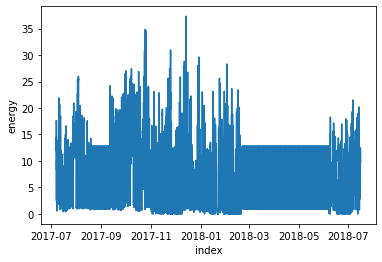

In [36]:
sns.lineplot(data=time_gaps.reset_index(), x = 'index', y = 'energy')

In [45]:
final_train = time_gaps.reset_index().rename({'index': 'time'}, axis = 1).drop(['hour'], axis = 1)

In [47]:
final_test =test_set.drop(['hour', 'time', 'time_transformed'], axis = 1).rename({'time_floored': 'time'}, axis = 1)

In [48]:
final_train.to_csv('training_set_imputed.csv', index = False)
final_test.to_csv('test_set_nonimputed.csv', index = False)

## Unused Cleaning Work

In [17]:
group_means = grouped_df.groupby(['time_floored']).mean()
group_means.head(5)

,Unnamed: 0.1,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,floor,hour
time_floored,,,,,,,,,,,,,,,
2017-07-07 13:00:00+00:00,1.5,72.166667,155.877500,75.000000,178.682083,6.927842,68.252500,63.000000,75.042083,208.814167,68.502500,63.000000,8.452033,2.0,13.0
2017-07-07 14:00:00+00:00,9.0,72.166667,329.305000,74.535152,342.958182,11.694974,70.620000,63.000000,74.470455,348.693030,71.006364,63.000000,11.833875,2.0,14.0
2017-07-07 15:00:00+00:00,20.0,72.166667,339.032273,74.087273,338.330455,11.122132,75.233636,62.181818,74.055455,340.718182,75.517273,62.090909,10.997212,2.0,15.0
2017-07-07 16:00:00+00:00,31.0,72.166667,399.698939,74.325152,403.138182,13.540660,76.127273,62.000000,74.317424,400.328030,76.201818,62.000000,13.563173,2.0,16.0
2017-07-07 17:00:00+00:00,42.0,72.166667,377.388636,74.193788,375.366818,12.887095,76.729091,62.000000,74.233333,379.173030,76.762727,62.000000,12.965098,2.0,17.0


In [27]:
group_means.shape[0] * 0.7 // 1

5907.0

In [28]:
1 + group_means.shape[0] * 0.7 // 1

5908.0

In [31]:
train_set = group_means.iloc[0: int(group_means.shape[0] * 0.7 // 1)]
test_set = group_means.iloc[int(group_means.shape[0] * 0.7 // 1):]

In [34]:
min_ts = train_set.index[0]
max_ts = train_set.index[len(train_set) - 1]

In [35]:
df = pd.DataFrame(index = pd.date_range(min_ts, max_ts, freq=time_val))

In [36]:
time_gaps = df.merge(train_set, left_index = True, right_index = True, how = 'outer')

In [37]:
time_gaps.loc[time_gaps['energy'].isna()].shape

(3950, 14)

In [45]:
train_set.index.hour

Int64Index([13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
            ...
            20, 21, 22, 23,  0,  1,  2,  3,  4,  5],
           dtype='int64', name='time_floored', length=5907)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [56]:
mean_per_hour = train_set.groupby('hour').mean()

In [57]:
mean_per_hour.head()

,Unnamed: 0.1,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,floor
hour,,,,,,,,,,,,,,
0,200.670966,71.980104,394.217588,73.484089,396.535187,12.652422,68.106149,52.394525,73.480181,395.305459,67.977380,52.411346,12.600795,2.431352
1,181.059938,71.978733,388.548221,73.469723,389.974829,12.159791,67.037128,52.660778,73.477373,387.286047,66.938162,52.684488,12.054795,2.428247
2,173.527479,71.983637,352.714661,73.608753,356.104404,10.910476,66.183299,52.776213,73.619743,351.093712,66.107610,52.785795,10.741096,2.432148
3,183.198744,71.984091,304.062631,73.707340,309.021905,9.436552,65.592419,52.883723,73.717237,304.441837,65.542856,52.888372,9.287921,2.432148
4,192.921045,71.982268,261.267050,73.791504,268.022058,8.085757,65.209207,52.936131,73.803987,263.533038,65.173692,52.942611,7.941843,2.432148


In [ ]:
# use these to fill NA values in the training_set

<AxesSubplot:xlabel='time_floored', ylabel='energy'>

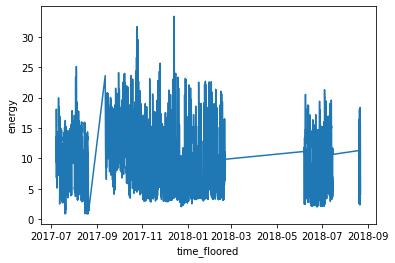

In [53]:
sns.lineplot(data=train_set.reset_index(), x = 'time_floored', y = 'energy')

In [ ]:
# instead of splitting here, use earlier split dates for actually 30/70% data

In [54]:
time_gaps.loc[:, 'hour'] = time_gaps.index.hour

In [40]:
time_gaps.loc[time_gaps['energy'].isna()].shape

(3109, 15)

In [ ]:
time_filled 

In [16]:
group_sums = grouped_df.groupby(['time_floored']).sum()
group_sums.head(5)

,Unnamed: 0.1,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,floor
time_floored,,,,,,,,,,,,,,
2017-07-07 13:00:00+00:00,36,1732.0,3741.06,1800.00,4288.37,166.268212,1638.06,1512.0,1801.01,5011.54,1644.06,1512.0,202.848801,48
2017-07-07 14:00:00+00:00,594,4763.0,21734.13,4919.32,22635.24,771.868307,4660.92,4158.0,4915.05,23013.74,4686.42,4158.0,781.035773,132
2017-07-07 15:00:00+00:00,1320,4763.0,22376.13,4889.76,22329.81,734.060713,4965.42,4104.0,4887.66,22487.40,4984.14,4098.0,725.815989,132
2017-07-07 16:00:00+00:00,2046,4763.0,26380.13,4905.46,26607.12,893.683532,5024.40,4092.0,4904.95,26421.65,5029.32,4092.0,895.169400,132
2017-07-07 17:00:00+00:00,2772,4763.0,24907.65,4896.79,24774.21,850.548293,5064.12,4092.0,4899.40,25025.42,5066.34,4092.0,855.696468,132


In [17]:
group_sums.shape

(8439, 14)

In [18]:
group_counts = grouped_df.groupby(['time_floored'])['Common Setpoint'].count().rename("count")

In [19]:
group_counts.head(5)

time_floored
2017-07-07 13:00:00+00:00    24
2017-07-07 14:00:00+00:00    66
2017-07-07 15:00:00+00:00    66
2017-07-07 16:00:00+00:00    66
2017-07-07 17:00:00+00:00    66
Name: count, dtype: int64

In [20]:
group_counts.min()

3

In [21]:
group_counts.max()

150

In [22]:
group_merge = group_sums.merge(group_counts, left_index = True, right_index = True)

In [23]:
group_merge.head(5)

,Unnamed: 0.1,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,floor,count
time_floored,,,,,,,,,,,,,,,
2017-07-07 13:00:00+00:00,36,1732.0,3741.06,1800.00,4288.37,166.268212,1638.06,1512.0,1801.01,5011.54,1644.06,1512.0,202.848801,48,24
2017-07-07 14:00:00+00:00,594,4763.0,21734.13,4919.32,22635.24,771.868307,4660.92,4158.0,4915.05,23013.74,4686.42,4158.0,781.035773,132,66
2017-07-07 15:00:00+00:00,1320,4763.0,22376.13,4889.76,22329.81,734.060713,4965.42,4104.0,4887.66,22487.40,4984.14,4098.0,725.815989,132,66
2017-07-07 16:00:00+00:00,2046,4763.0,26380.13,4905.46,26607.12,893.683532,5024.40,4092.0,4904.95,26421.65,5029.32,4092.0,895.169400,132,66
2017-07-07 17:00:00+00:00,2772,4763.0,24907.65,4896.79,24774.21,850.548293,5064.12,4092.0,4899.40,25025.42,5066.34,4092.0,855.696468,132,66


In [26]:
group_merge = group_merge.drop(['Unnamed: 0.1', 'floor'], axis = 1)

In [27]:
group_merge_mod = group_merge.multiply(group_counts.max() / group_merge['count'], axis = 'index')

In [28]:
group_merge_mod.head(5)

,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,count
time_floored,,,,,,,,,,,,,
2017-07-07 13:00:00+00:00,10825.0,23381.625000,11250.000000,26802.312500,1039.176322,10237.875000,9450.000000,11256.312500,31322.125000,10275.375000,9450.000000,1267.805007,150.0
2017-07-07 14:00:00+00:00,10825.0,49395.750000,11180.272727,51443.727273,1754.246152,10593.000000,9450.000000,11170.568182,52303.954545,10650.954545,9450.000000,1775.081301,150.0
2017-07-07 15:00:00+00:00,10825.0,50854.840909,11113.090909,50749.568182,1668.319803,11285.045455,9327.272727,11108.318182,51107.727273,11327.590909,9313.636364,1649.581792,150.0
2017-07-07 16:00:00+00:00,10825.0,59954.840909,11148.772727,60470.727273,2031.098937,11419.090909,9300.000000,11147.613636,60049.204545,11430.272727,9300.000000,2034.475908,150.0
2017-07-07 17:00:00+00:00,10825.0,56608.295455,11129.068182,56305.022727,1933.064302,11509.363636,9300.000000,11135.000000,56875.954545,11514.409091,9300.000000,1944.764700,150.0


In [29]:
energy_cols = group_merge_mod.loc[:, ['energy', 'energy Next']]
all_else = group_merge_mod.drop(['energy', 'energy Next'], axis = 1)
all_else = all_else / group_counts.max()

In [31]:
re_merge = all_else.merge(energy_cols, left_index = True, right_index = True)

In [32]:
all_else['Actual Supply Flow'].isna().sum()

0

In [209]:
sns?

<AxesSubplot:xlabel='time_floored', ylabel='Actual Supply Flow'>

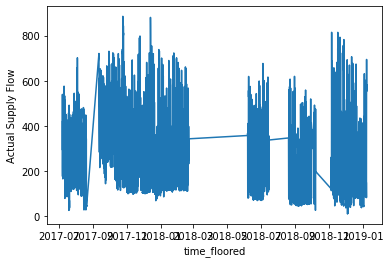

In [210]:
sns.lineplot(data = all_else.reset_index(), x = 'time_floored', y = 'Actual Supply Flow')

<AxesSubplot:xlabel='time_floored', ylabel='energy'>

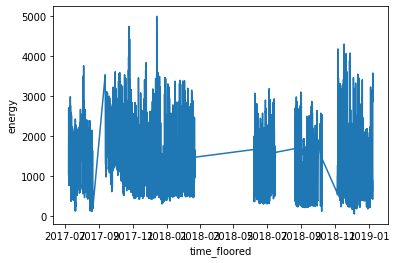

In [211]:
sns.lineplot(data = energy_cols.reset_index(), x = 'time_floored', y = 'energy')

In [35]:
min_ts = all_else.index[0]
max_ts = all_else.index[len(all_else) - 1]

In [37]:
df = pd.DataFrame(index = pd.date_range(min_ts, max_ts, freq=time_val))

In [38]:
time_gaps = df.merge(re_merge, left_index = True, right_index = True, how = 'outer')

In [40]:
time_gaps.loc[time_gaps['energy'].isna()].shape

(4748, 13)

In [61]:
grouped_df['hour'] = grouped_df['time_floored'].transform(lambda x: x.time().hour)

In [64]:
mean_per_hour = grouped_df.groupby('hour')['energy'].mean()

In [65]:
mean_per_hour

hour
0     12.031930
1     10.855814
2      9.638397
3      8.390945
4      7.296969
5      6.174673
6      5.351771
7      4.726385
8      4.597551
9      4.638416
10     4.429391
11     4.748580
12     5.336812
13     5.611395
14     7.507491
15     9.805022
16    11.265025
17    13.006065
18    14.460227
19    15.204219
20    15.010176
21    14.309833
22    13.579615
23    12.527954
Name: energy, dtype: float64

In [42]:
ffill_version = time_gaps.ffill()

In [43]:
bfill_version = time_gaps.bfill()

In [44]:
meanfill_version = time_gaps.fillna(time_gaps.mean())

In [45]:
medfill_version = time_gaps.fillna(time_gaps.median())

In [46]:
mixedfill = time_gaps.ffill(limit = 12).fillna(time_gaps.median())

In [226]:
time_gaps.shape

(13187, 13)

In [212]:
diff_ind = pd.date_range('2017-07-07 13:00:00+0000', '2019-01-07 23:00:00+0000', freq="1H").difference(all_else.index)


In [213]:
len(diff_ind)

4748

In [214]:
diff_ind[0:5]

DatetimeIndex(['2017-07-08 17:00:00+00:00', '2017-07-08 18:00:00+00:00',
               '2017-07-08 19:00:00+00:00', '2017-08-02 19:00:00+00:00',
               '2017-08-20 14:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

<AxesSubplot:>

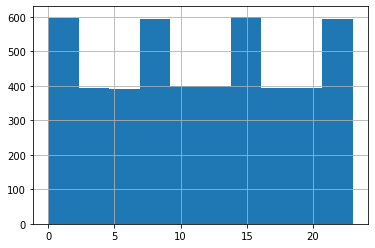

In [218]:
pd.Series(diff_ind.hour).hist()

In [49]:
time_gaps.head(1)

,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,count,energy,energy Next
2017-07-07 13:00:00+00:00,72.166667,155.8775,75.0,178.682083,68.2525,63.0,75.042083,208.814167,68.5025,63.0,1.0,1039.176322,1267.805007


<AxesSubplot:xlabel='index', ylabel='energy'>

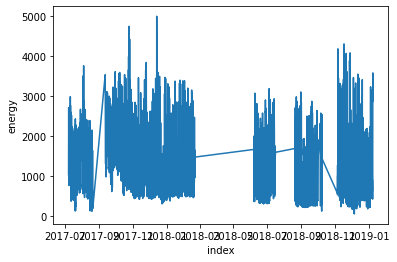

In [50]:
sns.lineplot(data = time_gaps.reset_index(), x = 'index', y = 'energy')

<AxesSubplot:xlabel='index', ylabel='energy'>

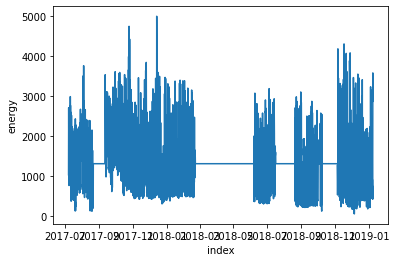

In [52]:
sns.lineplot(data = mixedfill.reset_index(), x = 'index', y = 'energy')

<AxesSubplot:xlabel='index', ylabel='energy'>

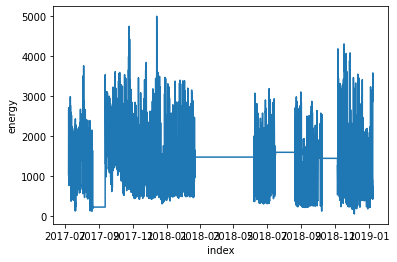

In [54]:
sns.lineplot(data = ffill_version.reset_index(), x = 'index', y = 'energy')

<AxesSubplot:xlabel='index', ylabel='energy'>

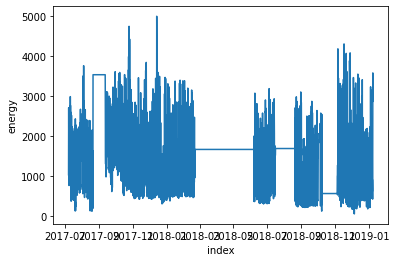

In [55]:
sns.lineplot(data = bfill_version.reset_index(), x = 'index', y = 'energy')

<AxesSubplot:xlabel='index', ylabel='energy'>

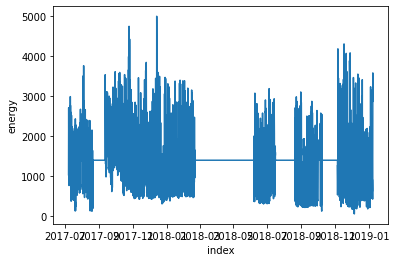

In [57]:
sns.lineplot(data = meanfill_version.reset_index(), x = 'index', y = 'energy')

<AxesSubplot:xlabel='index', ylabel='energy'>

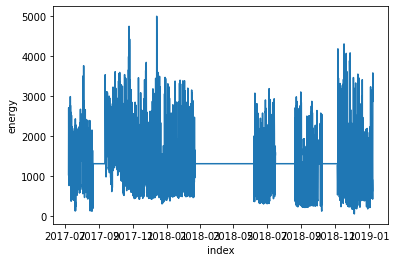

In [58]:
sns.lineplot(data = medfill_version.reset_index(), x = 'index', y = 'energy')

In [ ]:
# that's another option - do the split before and after the dates with the biggest period of missiness?

In [90]:
# According to this - if we follow this path, there are about 9523 missing values in the index

In [33]:
group_merge_mod['count'].value_counts()

75.0    16850
Name: count, dtype: int64

In [34]:
grouped_df_counts = grouped_df.groupby(['time_floored', 'Unnamed: 0.1'])['Common Setpoint'].count().rename("count")

In [35]:
grouped_df_counts.max()

9

In [36]:
grouped_df_counts.min()

1

In [37]:
grouped_df_means = grouped_df.groupby(['time_floored', 'Unnamed: 0.1']).mean()
grouped_df_means.columns += ["_mean"]

In [38]:
grouped_df_sums = grouped_df.groupby(['time_floored', 'Unnamed: 0.1']).sum()
grouped_df_sums.columns += ["_sum"]

In [39]:
counts_sums = grouped_df_sums.merge(grouped_df_counts.to_frame(), left_index = True, right_index = True, how = 'outer')

In [40]:
counts_sums = counts_sums.drop(['floor_sum'], axis = 1)

In [41]:
count_factors = (9 / counts_sums['count'])

In [42]:
counts_sums['factor'] = count_factors

In [43]:
counts_sums.head()

Common Setpoint_sum  \
time_floored              Unnamed: 0.1                        
2017-07-07 13:30:00+00:00 0                           433.0   
                          1                           433.0   
                          2                           433.0   
                          3                           433.0   
2017-07-07 14:00:00+00:00 4                           433.0   

                                        Actual Sup Flow SP_sum  \
time_floored              Unnamed: 0.1                           
2017-07-07 13:30:00+00:00 0                             939.75   
                          1                             933.75   
                          2                             938.23   
                          3                             929.33   
2017-07-07 14:00:00+00:00 4                            2068.26   

                                        Zone Temperature_sum  \
time_floored              Unnamed: 0.1                         
2017-07-07 13:30:00+00:00 0                           450.00   
                          1                           450.00   
                          2                           450.00   
                          3                           450.00   
2017-07-07 14:00:00+00:00 4                           451.01   

                                        Actual Supply Flow_sum  energy_sum  \
time_floored              Unnamed: 0.1                                       
2017-07-07 13:30:00+00:00 0                            1014.17   34.584364   
                          1                            1056.67   37.240799   
                          2                            1135.43   35.773216   
                          3                            1082.10   58.669832   
2017-07-07 14:00:00+00:00 4                            1737.34   71.164954   

                                        Outside Air Temp_sum  Humidity_sum  \
time_floored              Unnamed: 0.1                                       
2017-07-07 13:30:00+00:00 0                           407.64         378.0   
                          1                           408.00         378.0   
                          2                           410.64         378.0   
                          3                           411.78         378.0   
2017-07-07 14:00:00+00:00 4                           413.64         378.0   

                                        Zone Temperature Next_sum  \
time_floored              Unnamed: 0.1                              
2017-07-07 13:30:00+00:00 0                                450.00   
                          1                                450.00   
                          2                                450.00   
                          3                                451.01   
2017-07-07 14:00:00+00:00 4                                448.86   

                                        Actual Supply Flow Next_sum  \
time_floored              Unnamed: 0.1                                
2017-07-07 13:30:00+00:00 0                                 1056.67   
                          1                                 1135.43   
                          2                                 1082.10   
                          3                                 1737.34   
2017-07-07 14:00:00+00:00 4                                 2094.78   

                                        Outside Air Temp Next_sum  \
time_floored              Unnamed: 0.1                              
2017-07-07 13:30:00+00:00 0                                408.00   
                          1                                410.64   
                          2                                411.78   
                          3                                413.64   
2017-07-07 14:00:00+00:00 4                                417.00   

                                        Humidity Next_sum  energy Next_sum  \
time_floored              Unnamed: 0.1          

In [44]:
count_sums_mod = counts_sums.multiply(count_factors, axis = 'index')

In [45]:
count_sums_mod['count'].value_counts()

9.0    128799
Name: count, dtype: int64

In [46]:
count_sums_mod.head(5)

Common Setpoint_sum  \
time_floored              Unnamed: 0.1                        
2017-07-07 13:30:00+00:00 0                           649.5   
                          1                           649.5   
                          2                           649.5   
                          3                           649.5   
2017-07-07 14:00:00+00:00 4                           649.5   

                                        Actual Sup Flow SP_sum  \
time_floored              Unnamed: 0.1                           
2017-07-07 13:30:00+00:00 0                           1409.625   
                          1                           1400.625   
                          2                           1407.345   
                          3                           1393.995   
2017-07-07 14:00:00+00:00 4                           3102.390   

                                        Zone Temperature_sum  \
time_floored              Unnamed: 0.1                         
2017-07-07 13:30:00+00:00 0                          675.000   
                          1                          675.000   
                          2                          675.000   
                          3                          675.000   
2017-07-07 14:00:00+00:00 4                          676.515   

                                        Actual Supply Flow_sum  energy_sum  \
time_floored              Unnamed: 0.1                                       
2017-07-07 13:30:00+00:00 0                           1521.255   51.876546   
                          1                           1585.005   55.861199   
                          2                           1703.145   53.659825   
                          3                           1623.150   88.004748   
2017-07-07 14:00:00+00:00 4                           2606.010  106.747430   

                                        Outside Air Temp_sum  Humidity_sum  \
time_floored              Unnamed: 0.1                                       
2017-07-07 13:30:00+00:00 0                           611.46         567.0   
                          1                           612.00         567.0   
                          2                           615.96         567.0   
                          3                           617.67         567.0   
2017-07-07 14:00:00+00:00 4                           620.46         567.0   

                                        Zone Temperature Next_sum  \
time_floored              Unnamed: 0.1                              
2017-07-07 13:30:00+00:00 0                               675.000   
                          1                               675.000   
                          2                               675.000   
                          3                               676.515   
2017-07-07 14:00:00+00:00 4                               673.290   

                                        Actual Supply Flow Next_sum  \
time_floored              Unnamed: 0.1                                
2017-07-07 13:30:00+00:00 0                                1585.005   
                          1                                1703.145   
                          2                                1623.150   
                          3                                2606.010   
2017-07-07 14:00:00+00:00 4                                3142.170   

                                        Outside Air Temp Next_sum  \
time_floored              Unnamed: 0.1                              
2017-07-07 13:30:00+00:00 0                                612.00   
                          1                                615.96   
                          2                                617.67   
                          3                                620.46   
2017-07-07 14:00:00+00:00 4                                625.50   

                                        Humidity Next_sum  energy Next_sum  \
time_floored              Unnamed: 0.1          

In [56]:
pd.Series(count_sums_mod['energy Next_sum'].values[:-1] - count_sums_mod['energy_sum'].values[1:]).value_counts()

 0.000000     106712
-14.160707         1
-48.493978         1
-34.130220         1
 2.587150          1
               ...  
-24.019343         1
-59.951763         1
-11.518552         1
 21.757199         1
 85.433341         1
Length: 22087, dtype: int64

In [59]:
reset_sumsmod = count_sums_mod.reset_index()

In [64]:
reset_sumsmod.loc[reset_sumsmod['time_floored'] == '2017-07-07 15:00:00+00:00']

,time_floored,Unnamed: 0.1,Common Setpoint_sum,Actual Sup Flow SP_sum,Zone Temperature_sum,Actual Supply Flow_sum,energy_sum,Outside Air Temp_sum,Humidity_sum,Zone Temperature Next_sum,Actual Supply Flow Next_sum,Outside Air Temp Next_sum,Humidity Next_sum,energy Next_sum,count,factor
15,2017-07-07 15:00:00+00:00,15,649.5,3274.140,670.11,3173.760,120.498629,658.71,567.0,668.55,3632.925,658.71,567.0,100.376203,9.0,2.25
16,2017-07-07 15:00:00+00:00,16,649.5,3520.755,668.55,3632.925,100.376203,658.71,567.0,666.99,3052.455,668.79,567.0,90.069662,9.0,2.25
17,2017-07-07 15:00:00+00:00,17,649.5,2973.555,666.99,3052.455,90.069662,668.79,567.0,666.99,2772.885,673.29,558.0,89.530087,9.0,2.25
18,2017-07-07 15:00:00+00:00,18,649.5,2824.020,666.99,2772.885,89.530087,673.29,558.0,666.24,2766.495,675.54,558.0,91.221992,9.0,2.25
19,2017-07-07 15:00:00+00:00,19,649.5,2733.825,666.24,2766.495,91.221992,675.54,558.0,664.68,2821.125,678.96,558.0,105.548529,9.0,2.25
20,2017-07-07 15:00:00+00:00,20,649.5,2887.350,664.68,2821.125,105.548529,678.96,558.0,664.68,3236.220,679.50,558.0,92.678163,9.0,2.25


In [25]:
count_sums_mod.columns

Index(['Common Setpoint_sum', 'Actual Sup Flow SP_sum', 'Zone Temperature_sum',
       'Actual Supply Flow_sum', 'energy_sum', 'Outside Air Temp_sum',
       'Humidity_sum', 'Zone Temperature Next_sum',
       'Actual Supply Flow Next_sum', 'Outside Air Temp Next_sum',
       'Humidity Next_sum', 'energy Next_sum', 'count', 'factor'],
      dtype='object')

In [27]:
sums_avgs = count_sums_mod.merge(grouped_df_means, left_index = True, right_index = True)

In [29]:
sums_avgs.head(5)

Common Setpoint_sum  \
time_floored              Unnamed: 0.1                        
2017-07-07 13:30:00+00:00 0                           649.5   
                          1                           649.5   
                          2                           649.5   
                          3                           649.5   
2017-07-07 14:00:00+00:00 4                           649.5   

                                        Actual Sup Flow SP_sum  \
time_floored              Unnamed: 0.1                           
2017-07-07 13:30:00+00:00 0                           1409.625   
                          1                           1400.625   
                          2                           1407.345   
                          3                           1393.995   
2017-07-07 14:00:00+00:00 4                           3102.390   

                                        Zone Temperature_sum  \
time_floored              Unnamed: 0.1                         
2017-07-07 13:30:00+00:00 0                          675.000   
                          1                          675.000   
                          2                          675.000   
                          3                          675.000   
2017-07-07 14:00:00+00:00 4                          676.515   

                                        Actual Supply Flow_sum  energy_sum  \
time_floored              Unnamed: 0.1                                       
2017-07-07 13:30:00+00:00 0                           1521.255   51.876546   
                          1                           1585.005   55.861199   
                          2                           1703.145   53.659825   
                          3                           1623.150   88.004748   
2017-07-07 14:00:00+00:00 4                           2606.010  106.747430   

                                        Outside Air Temp_sum  Humidity_sum  \
time_floored              Unnamed: 0.1                                       
2017-07-07 13:30:00+00:00 0                           611.46         567.0   
                          1                           612.00         567.0   
                          2                           615.96         567.0   
                          3                           617.67         567.0   
2017-07-07 14:00:00+00:00 4                           620.46         567.0   

                                        Zone Temperature Next_sum  \
time_floored              Unnamed: 0.1                              
2017-07-07 13:30:00+00:00 0                               675.000   
                          1                               675.000   
                          2                               675.000   
                          3                               676.515   
2017-07-07 14:00:00+00:00 4                               673.290   

                                        Actual Supply Flow Next_sum  \
time_floored              Unnamed: 0.1                                
2017-07-07 13:30:00+00:00 0                                1585.005   
                          1                                1703.145   
                          2                                1623.150   
                          3                                2606.010   
2017-07-07 14:00:00+00:00 4                                3142.170   

                                        Outside Air Temp Next_sum  ...  \
time_floored              Unnamed: 0.1                             ...   
2017-07-07 13:30:00+00:00 0                                612.00  ...   
                          1                                615.96  ...   
                          2                                617.67  ...   
                          3                                620.46  ...   
2017-07-07 14:00:00+00:00 4                                625.50  ...   

                                        Actual Supply Flow_mean  energy_mean  \
time_floore

In [31]:
count_sums_mod.shape

(128799, 14)

In [30]:
sums_avgs.shape

(128799, 27)

In [32]:
grouped_df_means.shape

(128799, 13)

In [40]:
sums_avgs.iloc[20]

Common Setpoint_sum              649.500000
Actual Sup Flow SP_sum          2887.350000
Zone Temperature_sum             664.680000
Actual Supply Flow_sum          2821.125000
energy_sum                       105.548529
Outside Air Temp_sum             678.960000
Humidity_sum                     558.000000
Zone Temperature Next_sum        664.680000
Actual Supply Flow Next_sum     3236.220000
Outside Air Temp Next_sum        679.500000
Humidity Next_sum                558.000000
energy Next_sum                   92.678163
count                              9.000000
factor                             2.250000
Common Setpoint_mean              72.166667
Actual Sup Flow SP_mean          320.816667
Zone Temperature_mean             73.853333
Actual Supply Flow_mean          313.458333
energy_mean                       11.727614
Outside Air Temp_mean             75.440000
Humidity_mean                     62.000000
Zone Temperature Next_mean        73.853333
Actual Supply Flow Next_mean    

In [ ]:
# for these, does it make sense ot do a division for the other values and use averages, use some combination of both or what


# or should I impute differently? 

# talk about it with group tomorrow
# also in effect seems to be little/no difference between using 5 minute and 30 minutes based on shape, so I feel more comfortable with larger interval

In [87]:
diff_ind = pd.date_range('2017-07-07 13:30:00+0000', '2019-01-07 23:30:00+0000', freq="30T").difference(count_sums_mod.index.get_level_values(0))

In [88]:
len(diff_ind)

9523

In [89]:
diff_ind[0:5]

DatetimeIndex(['2017-07-08 17:00:00+00:00', '2017-07-08 17:30:00+00:00',
               '2017-07-08 18:00:00+00:00', '2017-07-08 18:30:00+00:00',
               '2017-07-08 19:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [90]:
# According to this - if we follow this path, there are about 9523 missing values in the index

<AxesSubplot:>

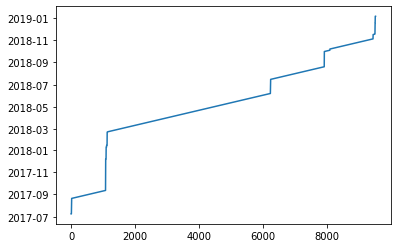

In [91]:
pd.Series(diff_ind).plot()

In [ ]:
# anotehr way of showing us visualziation we already knew - lots of missings at certain stretches (mainly late 2017 to earliy 2018), little everywhere else

In [ ]:
# how should we handle time and do we want to try to impute values between or what?

### Earlier Code Version - not using

floor_2_sums = floor_2.groupby(['time_floored', 'Unnamed: 0.1']).sum()
floor_2_sums.columns += ['_sum']

floor_3_sums = floor_3.groupby(['time_floored', 'Unnamed: 0.1']).sum()
floor_3_sums.columns += ['_sum']

floor_4_sums = floor_4.groupby(['time_floored', 'Unnamed: 0.1']).sum()
floor_4_sums.columns += ['_sum']

floor_2_means = floor_2.groupby(['time_floored_5min', 'Unnamed: 0.1']).mean()
floor_2_means.columns += ['_mean']

floor_3_means = floor_3.groupby(['time_floored_5min', 'Unnamed: 0.1']).mean()
floor_3_means.columns += ['_mean']

floor_4_means = floor_4.groupby(['time_floored_5min', 'Unnamed: 0.1']).mean()
floor_4_means.columns += ['_mean']